In [2]:
import numpy as np
import astropy.units as u
from astropy.io import fits
import time 
from importlib import reload
import copy
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
from IPython.display import clear_output

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle, Rectangle

import scoobi
from scoobi.math_module import xp, _scipy, ensure_np_array
from scoobi.imshows import imshow1, imshow2, imshow3
import scoobi.scoobi as scoobi
import scoobi.utils as utils

import lina

print(scoobi.__file__)
print(lina.__file__)

import purepyindi
from purepyindi import INDIClient
import purepyindi2
from purepyindi2 import IndiClient

client0 = INDIClient('localhost', 7624)
client0.start()

client = IndiClient()
client.connect()
client.get_properties()

def restart_clients():
    client0 = INDIClient('localhost', 7624)
    client0.start()

    client = IndiClient()
    client.connect()
    client.get_properties()

/home/kianmilani/Projects/scoob-interface/scoobi/scoobi.py
/home/kianmilani/Projects/lina/lina/__init__.py


In [3]:
reload(scoobi)
I = scoobi.SCOOBI(scicam_channel='camsci', dm_channel='dm00disp02')
I.npsf = 256

In [5]:
reload(scoobi)
xc, yc = (4600, 3400)
xc, yc = (4500, 3300)
npsf = 256
scoobi.set_zwo_roi(xc, yc, npsf, client0)


In [4]:
I.set_zwo_exp_time(0.0005, client0)

Set the ZWO exposure time to 5.00e-04s


In [5]:
I.set_zwo_gain(120, client0)

Set the ZWO gain setting to 120.0


In [6]:
I.set_fib_atten(34, client)

Set the fiber attenuation to 34.0


In [ ]:
scoobi.move_psf(50, 0, client0)

In [ ]:
scoobi.move_psf(0, -50, client0)

# Run FDPR2

In [10]:
from magpyx.utils import ImageStream
fdpr2_amp_stream = ImageStream('fdpr2_amp')
fdpr2_phs_stream = ImageStream('fdpr2_phase')

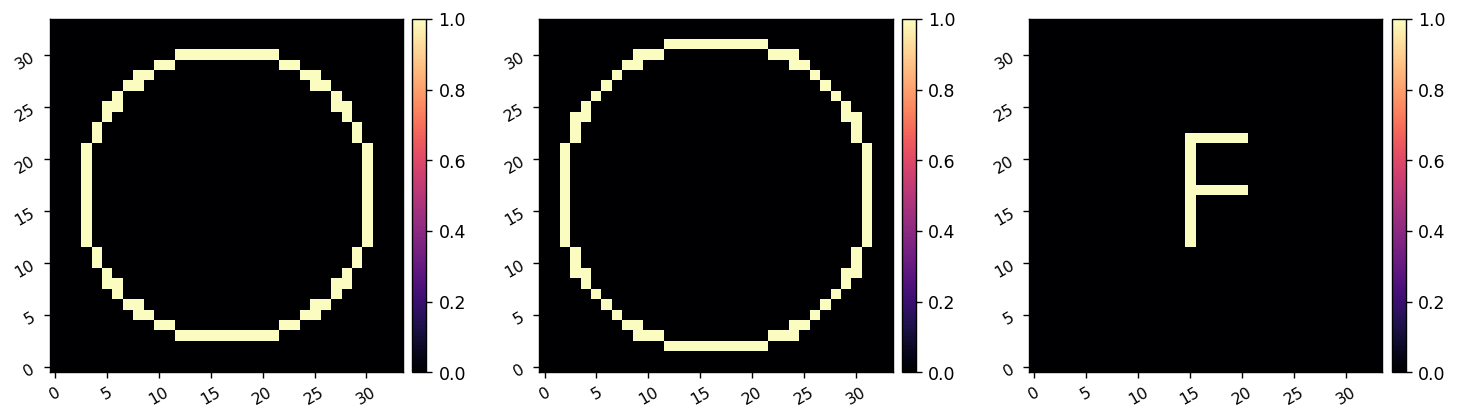

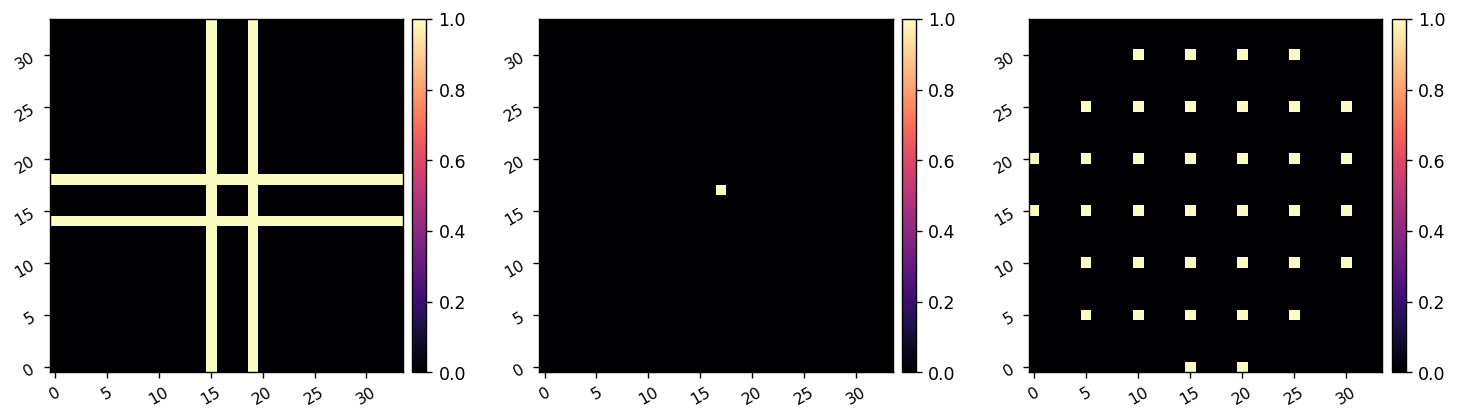

In [8]:
reload(lina.utils)

ring_13 = lina.utils.make_ring(rad=13, Nact=34)
ring_14 = lina.utils.make_ring(rad=14, Nact=34)
ring_15 = lina.utils.make_ring(rad=15, Nact=34)
ring_16 = lina.utils.make_ring(rad=16, Nact=34)
f = lina.utils.make_f()
imshow3(ring_14, ring_15, f)

cross = lina.utils.make_cross_command(xc=[-1, 3], yc=[2,-2])

poke = np.zeros((34,34))
poke[17,17] = 1
# poke[25,17] = 1
# poke[18,31] = 1

pokes = np.zeros((34,34))
for i in range(34):
    for j in range(34):
        if i%5==0 and j%5==0:
            pokes[i,j] = 1
pokes *= I.dm_mask
imshow3(cross, poke, pokes)

In [11]:
amp = 50e-9
# command = amp*ring_16
# command = amp*cross
# command = amp*poke
# command = amp*pokes
command = amp*f

I.set_dm(command)

INFO:utils:Got semaphore index 1.
INFO:fdpr2:Estimated phase RMS: 0.119 (rad)
INFO:fdpr2:Estimated amplitude RMS: 6.95 (%)
INFO:fdpr2:Estimated Strehl: 0.98 (0.99 phase-only and 0.99 amplitude-only)
INFO:fdpr2:Updated shmims fdpr2_phase and fdpr2_amp


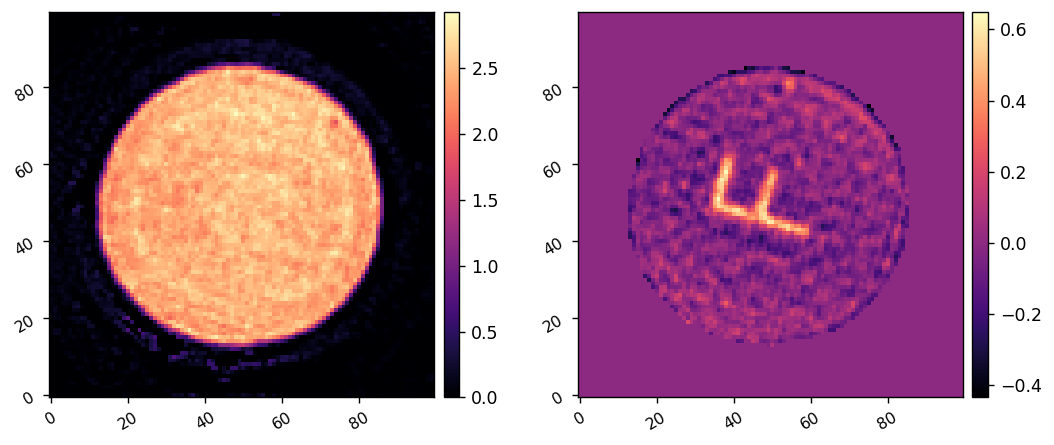

In [12]:
from magpyx.fdpr2 import console, tools

config_params = tools.Configuration('fdpr2_fpm')
# config_params = tools.Configuration('fdpr2_kilo_dmdiv_km')

fitdict, Imeas_cen = console.estimate_oneshot(config_params)
I.zero_dm()

fitdict.update({
    'AMP':fdpr2_amp_stream.grab_latest(),
    'PHS':fdpr2_phs_stream.grab_latest(),
    'dm_command':command,
    'Imeas':Imeas_cen, 
})

imshow2(fitdict['AMP'], fitdict['PHS'], npix=100)

In [88]:
utils.save_pickle(f'{today}_fdpr2_ref.pkl', fitdict)
# utils.save_pickle(f'{today}_fdpr2_ring_14.pkl', fitdict)
# utils.save_pickle(f'{today}_fdpr2_ring_15.pkl', fitdict)
# utils.save_pickle(f'{today}_fdpr2_ring_16.pkl', fitdict)
# utils.save_pickle(f'{today}_fdpr2_f.pkl', fitdict)
# utils.save_pickle(f'{today}_fdpr2_cross.pkl', fitdict)
# utils.save_pickle(f'{today}_fdpr2_poke_1.pkl', fitdict)
# utils.save_pickle(f'{today}_fdpr2_double_pokes.pkl', fitdict)
# utils.save_pickle(f'{today}_fdpr2_pokes.pkl', fitdict)


Saved data to:  20250113_fdpr2_ref.pkl


In [33]:
I.zero_dm()